In [19]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import shap
import json
from IPython.display import display

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


In [20]:
enc_data = pd.read_csv('data/stu_risk_data_encoded.csv')
enc_data.head()

,Gender,Age [10-15],Age [16-20],Age [21-25],Age [26-30],Age [31-35],Level,access_to_material_in my academy,family_financial_status_allows_me_to_focus,parent_guardian_support_education_learning,...,rarely_have_conflict_with_classmate_lecturer,constantly_attend_lectures_on_time,avoid_engaging _risky_behavior,family_status_stable_supportive_in _academic_pursuits,parent_guardian_encourages_academic_pursuit,no_significant_family_issues_interfere_academic_pursuit,strong_sense_belonging_university_community,University_provide_adequate_support_academic_pursuit,feel_safe_comfortable_in_school_environment,What_ your_current_CGPA
0,1,0,0,0,0,1,3,3,0,0,...,4,3,0,3,2,1,3,1,2,2
1,1,0,0,1,0,0,2,3,0,0,...,4,3,1,3,0,0,3,2,2,2
2,1,0,0,1,0,0,0,4,6,5,...,1,4,1,3,3,3,1,2,2,3
3,1,0,1,0,0,0,1,3,5,4,...,3,3,1,4,3,3,4,3,4,1
4,1,0,0,1,0,0,2,1,2,4,...,3,0,3,3,3,4,3,3,2,1


In [21]:
X = enc_data[['Gender','Level','parent_guardian_support_education_learning',
             'positive_supportive_relation_with_lecturers', 
             'avoid_engaging _risky_behavior', 'family_status_stable_supportive_in _academic_pursuits',
             'parent_guardian_encourages_academic_pursuit',
             'no_significant_family_issues_interfere_academic_pursuit',
            'strong_sense_belonging_university_community','University_provide_adequate_support_academic_pursuit',
             'feel_safe_comfortable_in_school_environment']]
y = enc_data['What_ your_current_CGPA']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Training feature shape is {X_train.shape}')
print(f'Test feature shape is {X_test.shape}')

Training feature shape is (1387, 11)
Test feature shape is (347, 11)


In [22]:
class StuRiskModelEvaluator:
    def __init__(self, models):
        self.models = models
        self.metrics_comparison = {
            'Model': [],
            'Accuracy': [],
            'F1 Score': [],
            'Precision': [],
            'Recall': [],
            'ROC AUC': []
        }

    def evaluate_models(self, X_train, X_test, y_train, y_test):
        # Binarize the output for multi-class ROC AUC
        n_classes = len(np.unique(y_test))
        y_test_bin = label_binarize(y_test, classes=np.unique(y_test)) if n_classes > 2 else y_test

        plt.figure(figsize=(20, 15))

        for idx, (model_name, model) in enumerate(self.models.items(), 1):
            # Train the model
            model.fit(X_train, y_train)

            # Predictions
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None

            # Metrics
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='macro')
            precision = precision_score(y_test, y_pred, average='macro')
            recall = recall_score(y_test, y_pred, average='macro')
            roc_auc = self._calculate_roc_auc(y_test, y_test_bin, y_pred_proba, n_classes)

            # Store metrics
            self._store_metrics(model_name, accuracy, f1, precision, recall, roc_auc)

            # Confusion Matrix Heatmap
            self._plot_confusion_matrix(y_test, y_pred, model_name, idx)

        plt.tight_layout()
        plt.show()
    
        # Display Metrics Table
        self._display_metrics_table()
        
        # Feature Importance and SHAP
        self._plot_feature_importance(self.models, X_test)

        # Metrics Comparison Bar Chart
        self._plot_metrics_comparison()

        # ROC Curves
        self._plot_roc_curves(self.models, X_test, y_test, y_test_bin, n_classes)

        return pd.DataFrame(self.metrics_comparison)

    def _calculate_roc_auc(self, y_test, y_test_bin, y_pred_proba, n_classes):
        if y_pred_proba is not None and n_classes > 2:
            return roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr')
        elif y_pred_proba is not None:
            return roc_auc_score(y_test, y_pred_proba[:, 1])
        else:
            return None

    def _store_metrics(self, model_name, accuracy, f1, precision, recall, roc_auc):
        self.metrics_comparison['Model'].append(model_name)
        self.metrics_comparison['Accuracy'].append(accuracy)
        self.metrics_comparison['F1 Score'].append(f1)
        self.metrics_comparison['Precision'].append(precision)
        self.metrics_comparison['Recall'].append(recall)
        self.metrics_comparison['ROC AUC'].append(roc_auc)

    def _display_metrics_table(self):
        metrics_df = pd.DataFrame(self.metrics_comparison)

        metrics_df = metrics_df.style.set_table_styles(
            [{'selector': 'th', 'props': [('text-align', 'center')]},
             {'selector': 'td', 'props': [('text-align', 'center')]}]
        ).set_properties(**{'width': '120px'}).format(
            {'Accuracy': '{:.2%}', 'F1 Score': '{:.2%}', 'Precision': '{:.2%}', 'Recall': '{:.2%}', 'ROC AUC': '{:.2%}'}
        )

        display(metrics_df)
    
    def _plot_confusion_matrix(self, y_test, y_pred, model_name, idx):
        plt.subplot(2, 2, idx)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{model_name} Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')

    def _plot_feature_importance(self, models, X_test):
        plt.figure(figsize=(20, 15))

        for idx, (model_name, model) in enumerate(models.items(), 1):
            if model_name in ['Random Forest']:
                explainer = shap.TreeExplainer(model)
                shap_values = explainer.shap_values(X_test)
                plt.subplot(2, 2, idx)
                shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
                plt.title(f'{model_name} SHAP Feature Importance')

        plt.tight_layout()
        plt.show()

    def _plot_metrics_comparison(self):
        metrics_df = pd.DataFrame(self.metrics_comparison)
        metrics_to_plot = ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'ROC AUC']

        plt.figure(figsize=(12, 6))
        for i, metric in enumerate(metrics_to_plot, 1):
            plt.subplot(1, 5, i)
            plt.bar(metrics_df['Model'], metrics_df[metric], color='skyblue')
            plt.title(metric)
            plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        plt.show()

    def _plot_roc_curves(self, models, X_test, y_test, y_test_bin, n_classes):
        plt.figure(figsize=(12, 8))

        for model_name, model in models.items():
            if hasattr(model, 'predict_proba'):
                y_pred_proba = model.predict_proba(X_test)

                if n_classes > 2:
                    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
                    roc_auc = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr')
                else:
                    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
                    roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

                plt.plot(fpr, tpr, label=f'{model_name} (AUC: {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('ROC Curves for All Models', fontsize=15)
        plt.legend(loc='lower right', fontsize=10)
        plt.grid(alpha=0.5)
        plt.tight_layout()
        plt.show()
                
    def predict(self, model_name, input_row, category_mapping_path='category_mapping.json'):
        """
        Predicts the output for a given input row using the specified model.
        
        Parameters:
        - model_name (str): The name of the model to use for prediction.
        - input_row (dict or pd.DataFrame): A single input row for prediction.
        - category_mapping_path (str): Path to the category mapping JSON file.

        Returns:
        - dict: Encoded prediction and human-readable prediction.
        """
        if model_name not in self.models:
            raise ValueError(f"Model '{model_name}' not found in the evaluator.")

        model = self.models[model_name]

        if isinstance(input_row, dict):
            input_row = pd.DataFrame([input_row])
        elif not isinstance(input_row, pd.DataFrame):
            raise ValueError("Input row must be a dictionary or a pandas DataFrame row.")

        predicted_encoded = model.predict(input_row)[0]

        with open(category_mapping_path, 'r') as f:
            category_map = json.load(f)

        cgpa_mapping = {v: k for k, v in category_map['What_ your_current_CGPA'].items()}
        predicted_human_readable = cgpa_mapping[predicted_encoded]

        return {
            'Encoded Prediction': predicted_encoded,
            'Human-Readable Prediction': predicted_human_readable
        }

        plt.tight_layout()
        plt.show()

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


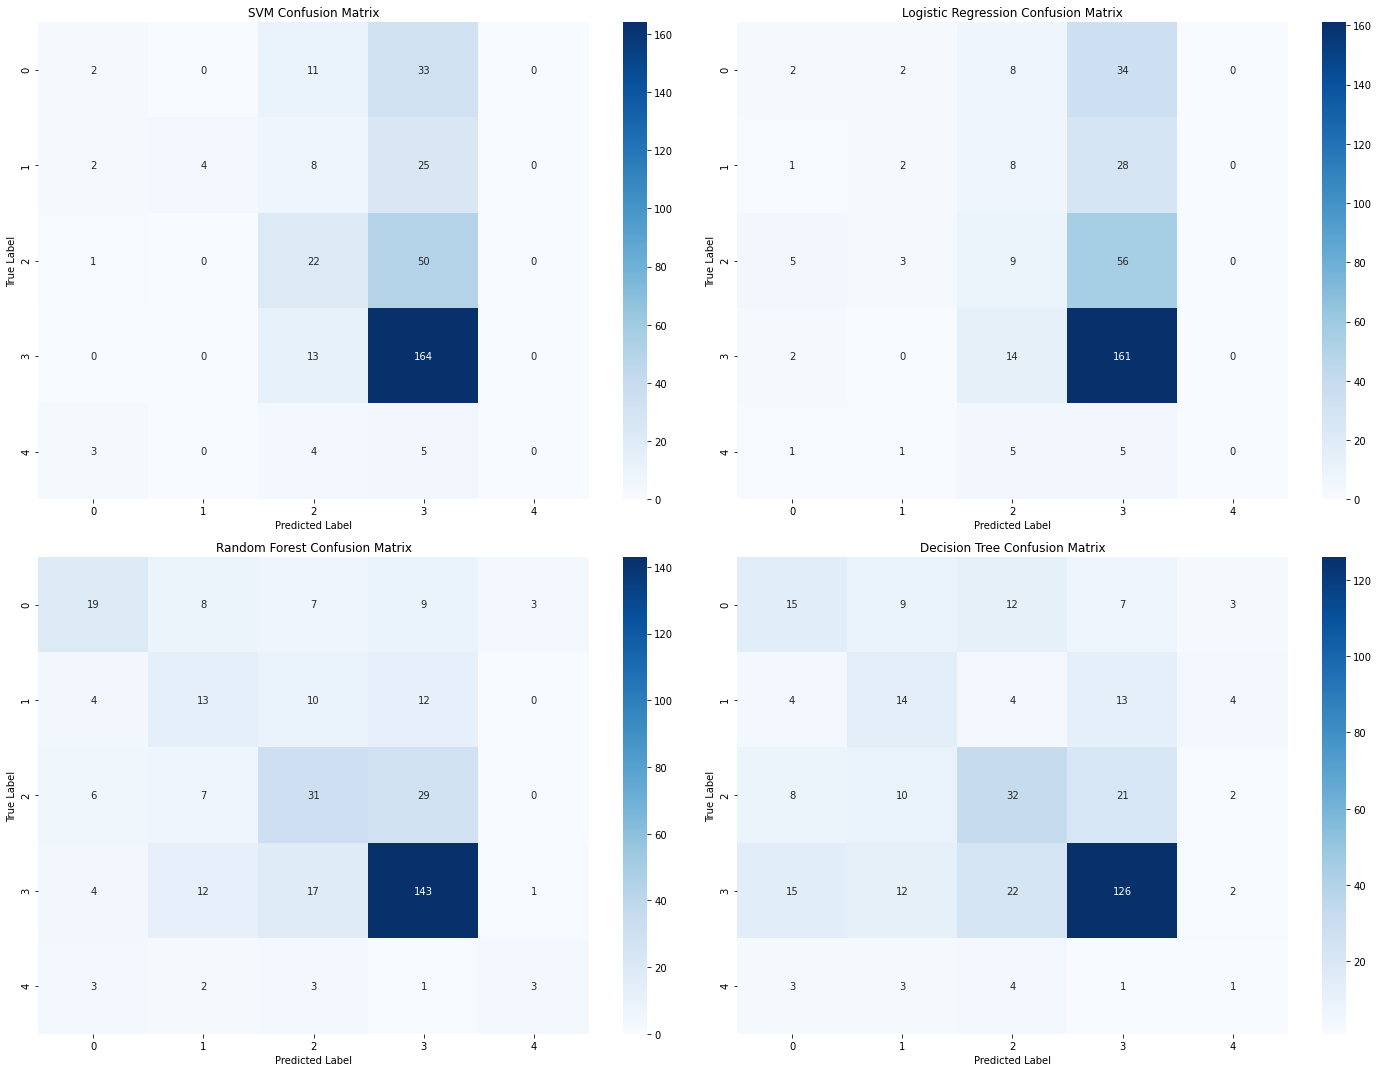

,Model,Accuracy,F1 Score,Precision,Recall,ROC AUC
0,SVM,55.33%,26.37%,44.43%,27.48%,70.12%
1,Logistic Regression,50.14%,20.15%,24.07%,22.55%,63.17%
2,Random Forest,60.23%,46.22%,49.18%,44.58%,78.49%
3,Decision Tree,54.18%,38.01%,37.82%,38.37%,62.91%


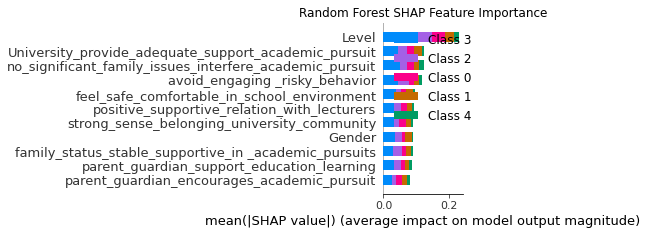

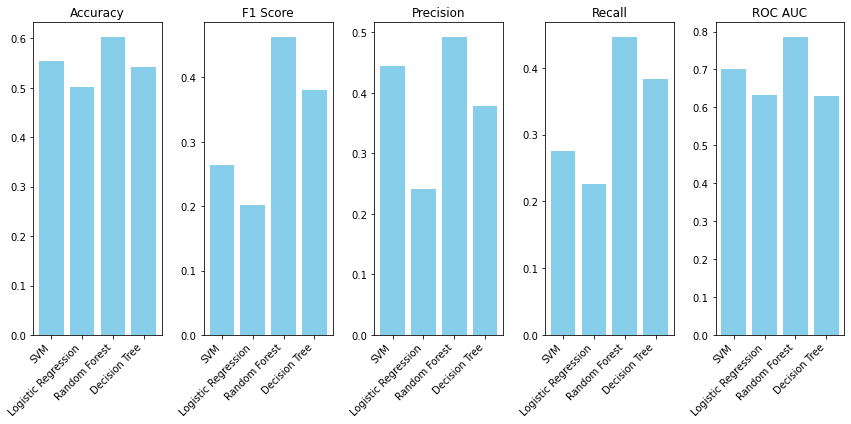

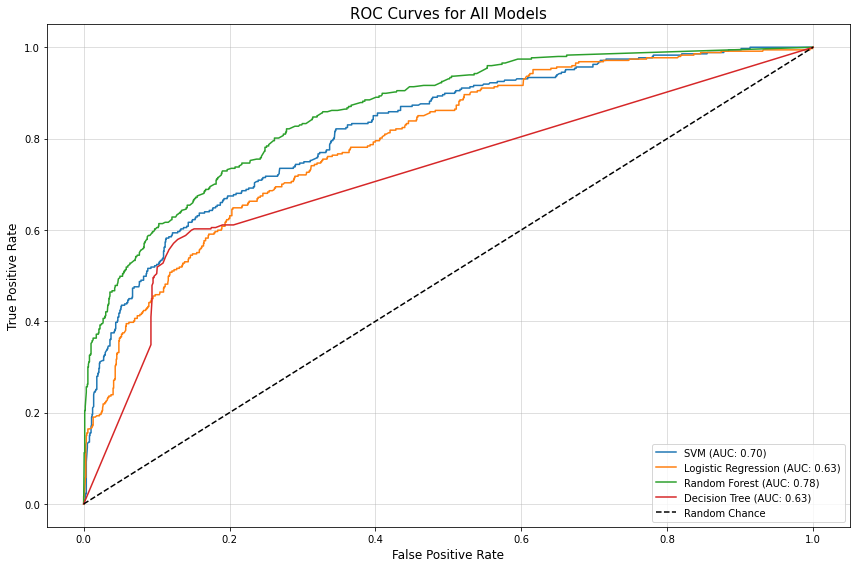

Encoded Prediction: 3
CGPA: 4.5 and above


In [23]:
models = {
    'SVM': SVC(probability=True),
    'Logistic Regression': LogisticRegression(multi_class='ovr', max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier()
}

evaluator = StuRiskModelEvaluator(models)
results = evaluator.evaluate_models(X_train, X_test, y_train, y_test)
import pandas as pd

new_row = {
    'Gender': 1,  # Male
    'Level': 2,  # 400L
    'parent_guardian_support_education_learning': 3,  # Strongly Agree
    'positive_supportive_relation_with_lecturers': 3,  # Strongly Agree
    'avoid_engaging _risky_behavior': 3,  # Not Frequently
    'family_status_stable_supportive_in _academic_pursuits': 3,  # Stable
    'parent_guardian_encourages_academic_pursuit': 3,  # Strongly Agree
    'no_significant_family_issues_interfere_academic_pursuit': 2,  # Neutral
    'strong_sense_belonging_university_community': 3,  # Strong Sense of Belonging
    'University_provide_adequate_support_academic_pursuit': 4,  # Strong Support
    'feel_safe_comfortable_in_school_environment': 3  # Strongly Agree
}

# Predict using a specific model
result = evaluator.predict(model_name='Random Forest', input_row=new_row)

# Display the prediction
print("Encoded Prediction:", result['Encoded Prediction'])
print("CGPA:", result['Human-Readable Prediction'])
